In [160]:
import matplotlib.pyplot as plt # for images and metrics visualization
import numpy as np # to manipulation nd arrays 
import tensorflow as tf # for tensors manipulation and deep learning models developing
import pathlib # for paths manipulation

from tensorflow import keras # keras is a high level api to develop DL architectures
from tensorflow.keras import layers # the modules to create different model layers
from tensorflow.keras.models import Sequential # to instansiate the model architecture

In [161]:
# store directories paths 
train_dir = pathlib.Path("../Data/train")  
test_dir = pathlib.Path("../Data/test") 

# count the number of images in each folder (train / test)
train_image_count = len(list(train_dir.glob('*/*.png')))  
test_image_count = len(list(test_dir.glob('*/*.png')))
print(train_image_count)
print(test_image_count)

28709
7169


In [162]:
# initiate our hyperparameters
batch_size = 32
img_height = 48
img_width = 48

In [163]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",  # Set color_mode to grayscale
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",  # Set color_mode to grayscale
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",  # Set color_mode to grayscale
    shuffle=False  # No need to shuffle test dataset
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7169 files belonging to 7 classes.


In [164]:
# Extract classes 
class_names = train_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


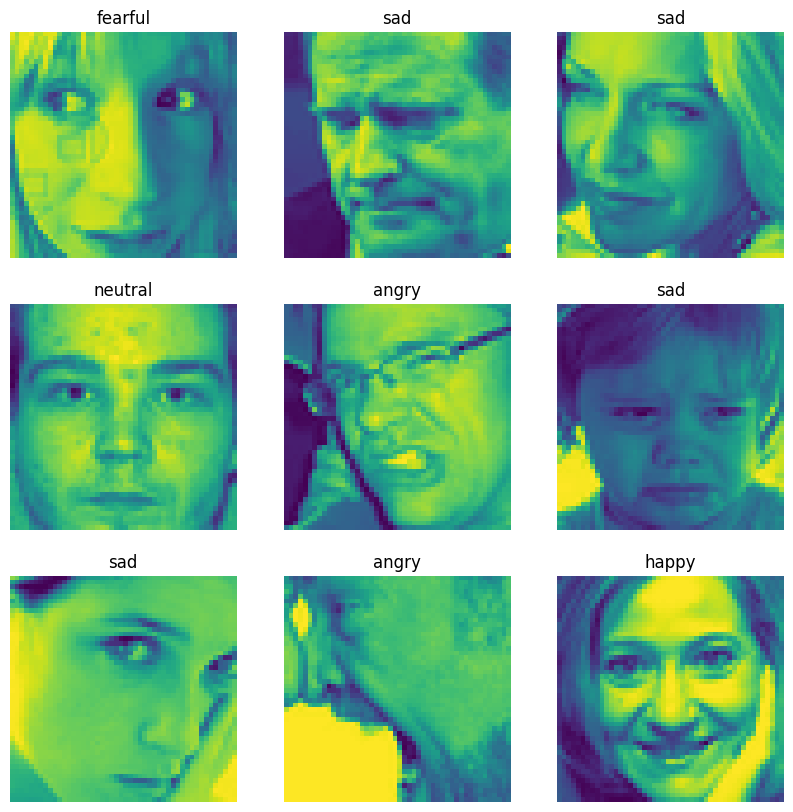

In [165]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [166]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [167]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)), 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [168]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [169]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 64)      

In [170]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
718/718 [==============================] - 16s 21ms/step - loss: 1.6329 - accuracy: 0.3570 - val_loss: 1.5252 - val_accuracy: 0.4107
Epoch 2/10
718/718 [==============================] - 15s 22ms/step - loss: 1.3868 - accuracy: 0.4691 - val_loss: 1.3753 - val_accuracy: 0.4835
Epoch 3/10
718/718 [==============================] - 17s 24ms/step - loss: 1.2580 - accuracy: 0.5191 - val_loss: 1.2895 - val_accuracy: 0.5083
Epoch 4/10
718/718 [==============================] - 16s 22ms/step - loss: 1.1618 - accuracy: 0.5618 - val_loss: 1.3206 - val_accuracy: 0.5084
Epoch 5/10
718/718 [==============================] - 15s 21ms/step - loss: 1.0708 - accuracy: 0.5967 - val_loss: 1.2421 - val_accuracy: 0.5442
Epoch 6/10
718/718 [==============================] - 15s 21ms/step - loss: 0.9853 - accuracy: 0.6324 - val_loss: 1.2520 - val_accuracy: 0.5429
Epoch 7/10
718/718 [==============================] - 15s 21ms/step - loss: 0.8983 - accuracy: 0.6632 - val_loss: 1.2979 - val_accuracy:

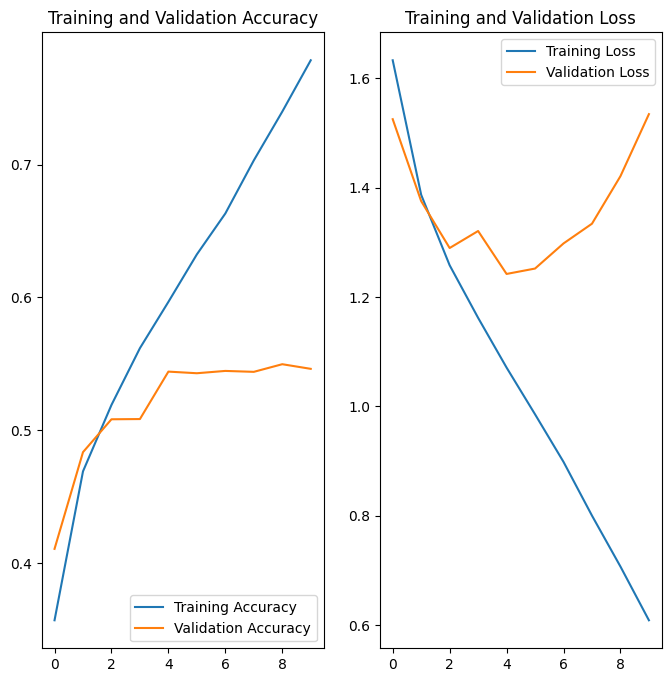

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [172]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

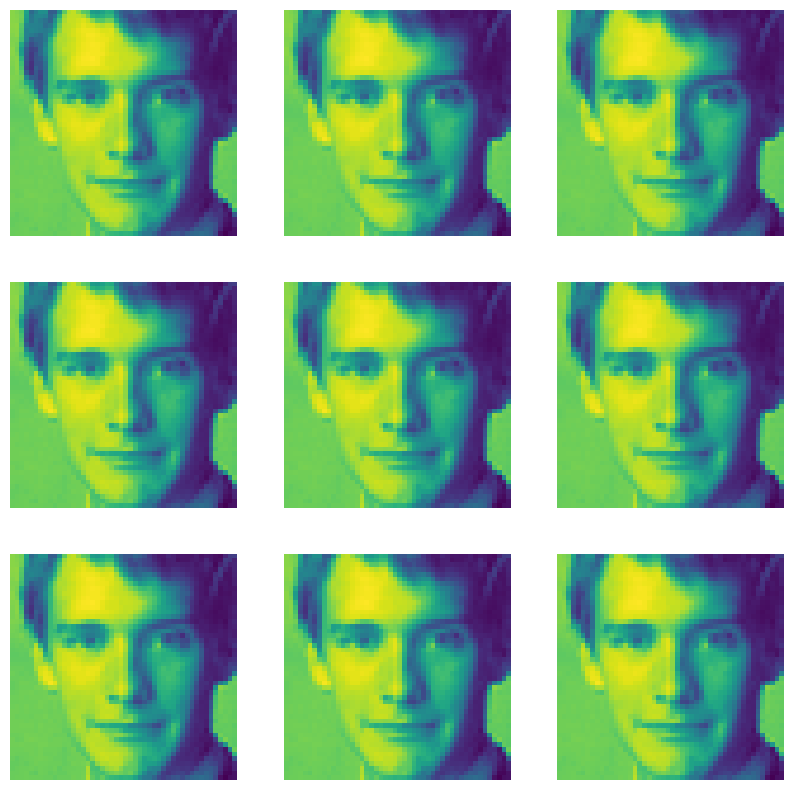

In [173]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [215]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
num_classes = len(class_names)

data_augmentation = Sequential([
    RandomFlip("horizontal"),  # Add horizontal flip augmentation
    RandomRotation(0.1)  # Add random rotation augmentation
])
model = Sequential([
    data_augmentation,  # Apply data augmentation
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)), 
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [216]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None, img_height, img_width, 1))

In [217]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 48, 48, 1)         0         
                                                                 
 rescaling_14 (Rescaling)    (None, 48, 48, 1)         0         
                                                                 
 conv2d_42 (Conv2D)          (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                

In [218]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/25


718/718 [==============================] - 20s 26ms/step - loss: 1.7487 - accuracy: 0.2874 - val_loss: 1.6551 - val_accuracy: 0.3696
Epoch 2/25
718/718 [==============================] - 23s 32ms/step - loss: 1.6093 - accuracy: 0.3662 - val_loss: 1.5456 - val_accuracy: 0.3982
Epoch 3/25
718/718 [==============================] - 24s 34ms/step - loss: 1.5085 - accuracy: 0.4122 - val_loss: 1.4547 - val_accuracy: 0.4456
Epoch 4/25
718/718 [==============================] - 25s 35ms/step - loss: 1.4464 - accuracy: 0.4455 - val_loss: 1.3882 - val_accuracy: 0.4754
Epoch 5/25
718/718 [==============================] - 25s 34ms/step - loss: 1.3968 - accuracy: 0.4619 - val_loss: 1.3506 - val_accuracy: 0.4926
Epoch 6/25
718/718 [==============================] - 23s 32ms/step - loss: 1.3607 - accuracy: 0.4788 - val_loss: 1.3153 - val_accuracy: 0.5083
Epoch 7/25
718/718 [==============================] - 22s 30ms/step - loss: 1.3244 - accuracy: 0.4936 - val_loss: 1.3090 - val_accuracy: 0.5060
Epo

In [219]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)

# Print the loss and accuracy
print("Loss: ", loss)
print("Accuracy: ", accuracy)

225/225 [==============================] - 1s 6ms/step - loss: 1.2060 - accuracy: 0.5437
Loss:  1.206030249595642
Accuracy:  0.5437299609184265


In [226]:
im_path = "../Data/train/angry/im11.png"
img = tf.keras.utils.load_img(
    im_path, color_mode="grayscale", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 26ms/step
This image most likely belongs to angry with a 51.19 percent confidence.


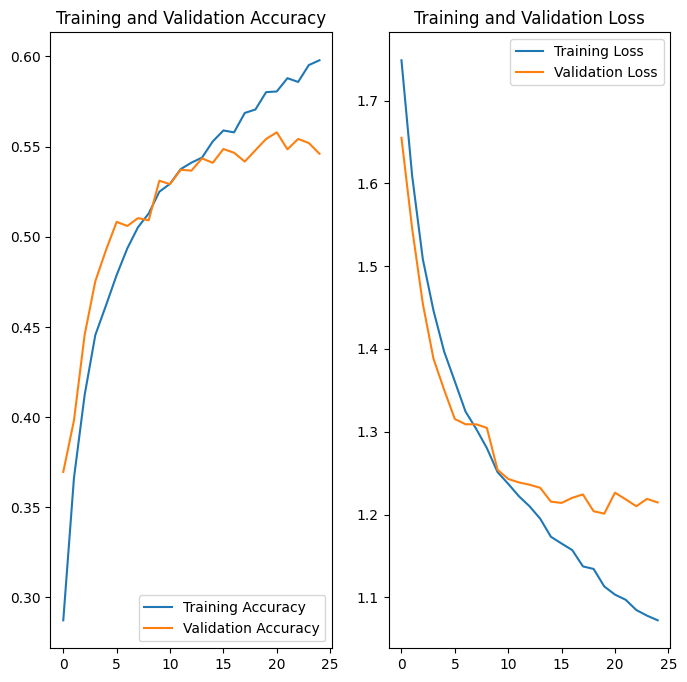

In [227]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [211]:
model.save("EmotionDetecttor_2")

INFO:tensorflow:Assets written to: EmotionDetecttor_2\assets


INFO:tensorflow:Assets written to: EmotionDetecttor_2\assets


In [212]:
recons_model = tf.keras.models.load_model("EmotionDetecttor_2")

In [213]:
pr = recons_model.predict(img_array)
sc=tf.nn.softmax(pr[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(sc)], 100 * np.max(sc))
)

1/1 [==============================] - 0s 77ms/step
This image most likely belongs to sad with a 26.72 percent confidence.


In [228]:
from keras.models import model_from_json

# Save model to JSON
model_json = model.to_json()
with open("emotiondetector.json", 'w') as json_file:
    json_file.write(model_json)

# Save model weights to HDF5
model.save_weights("emotiondetector.h5")